#  Short-term Traffic Counts  Missing Data Techiniques Comparison  

### Introduction
In order to compare the effective of traffic count  missing data imputation techniques, experiments were conducted for scenarios  of the combination of different daily traffic volumes levels  and proportions of missing data.
    
MAG 2010 dataset was used for the experiment. Traffic counts of two days from the same location and same direction (N/E or S/W) were chosen for analysis.
 
 Assuming data are missing by block (continuous points) and missing data are starting from 8am (Start from point 32). Four missing scenarios were considered:
 - 1 hours (4/96) 8am-9m
 - 2 hours (8/96) 8am-10am
 - 4 hours (16/96) 8am-12pm
 - 8 hours (32/96) 8am-4pm
 
 The following missing value techniques were used and compared:
 
 -  Last observation carried forward or Next observation carried backward
 -  Linear regression
 -  Locally weighted regression
 -  k-nearest neighbors
 
 Performance measures: 
 - RMSE percent: RMSE/average count
 - Correlation coefficient r
 
 In the end,  performance measures by volume group are summarized: 
 - 100,000 or more
 - 50,000~99,999
 - 10,000~49,999
 - 5,000~9,999
 - 1,000~4,999
 - Less than 1,000

# 1. Input Data & Data preparation

In [205]:
import os
import pandas as pd
import numpy as np
from itertools import chain
import random
#import scipy.interpolate
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from scipy.spatial import distance
import statistics as stp

In [380]:
os.chdir('I:/10_STAFF/YP/Data Smoothing Techniques  Comparison')
df= pd.read_csv('15min.csv')
df_blocks= pd.read_csv('missing_block.csv')
df=df[df['Num_of_Days']==2]
df["Loc_ID"] = df["Site_ID"].map(str) + df["True_Dir"]
df_1=df[df['Day']==1].sample(500, random_state =1)
df_2=df[df['Day']==2]
df_2=df_2[df_2['Loc_ID'].isin(df_1['Loc_ID'])]

df1=df_1.append(df_2, ignore_index=True).sort_values(by=['Loc_ID', 'Day'])

In [381]:
#df1=df1[df1['Total']>100000]

In [382]:
#df_blocks

In [383]:
df2=pd.concat([df1.iloc[:,5], df1.iloc[:,9:106]], axis=1)
df2.head()

,Day,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,Loc_ID
270,1,20,9,14,9.0,7,7,6,9,8,...,69,50,33,38,35,41,22,21,20,T0001NB
500,2,18,15,15,18.0,10,11,16,12,11,...,54,62,35,34,32,31,30,32,25,T0001NB
351,1,15,7,9,8.0,12,9,5,5,7,...,69,37,31,31,35,31,15,17,17,T0003SB
697,2,6,13,4,11.0,6,9,9,4,5,...,41,30,45,37,15,27,29,14,25,T0003SB
327,1,16,30,12,20.0,16,7,12,12,16,...,66,58,50,54,45,29,41,38,20,T0005SB


# 2. Data Imputation

try one missing scenario first

In [467]:
result = []
groups = df2.groupby('Loc_ID')
for n,g in groups:
    #print('This is loc '+ str(n)+'.')
    g.drop(g.columns[[97]], axis=1, inplace=True)
    
    g_o=g.set_index('Day').T
    g_o.index = g_o.index.map(int)
    
    g1=g.set_index('Day').T
    g1.index = g1.index.map(int)
    
    
    #print('orginal: ')
    #print(g_o)
    
    # Set basic parameters
    proportion = 16/96
    block_size = 16
    number_of_samples = int((g1.shape[0] * proportion) / block_size)
    
    
    # This will hold all indexes to be set to NaN
    block_indexes = []

    i = 0

    # Iterate until number of samples are found
    while i < number_of_samples:

    # Choose a potential start and end
         #potential_start = random.sample(list(g1.index), 1)[0]
        potential_start = 32
        potential_end = potential_start + block_size

    # Flatten the list of lists
        flattened_indexes = list(chain(*block_indexes))

    # Check to make sure potential start and potential end are not already in the indexes
        if potential_start not in flattened_indexes \
        and potential_end not in flattened_indexes:

        # If they are not, append the block indexes
             block_indexes.append(list(range(potential_start, potential_end)))
             i += 1
        
    # Flatten the list of lists
    #block_indexes = list(chain(*block_indexes))
    block_indexes=range(32, 32+block_size)
    
    # Set the blocks to nan accounting for end of dataframe
    g1.loc[[x for x in block_indexes if x in g1.index], 2] = np.nan
    #print("missing:")
    #print(g1.loc[32:32+block_size-1])
    #print('\n')


    g_combine=g1.merge(g_o, left_index=True, right_index=True) 
    g_combine2=g1.merge(g_o, left_index=True, right_index=True) 
    g_combine3=g1.merge(g_o, left_index=True, right_index=True) 

    
    ##missing value imputation (Assumption: Day1 and Day2 should have the same pattern and similar volumme)
    ##method 1: replace using the same value of another day
    g_combine['2_x'] = np.where( np.isnan(g_combine['2_x']), g_combine['1_x'],  g_combine['2_x'])

    #print("Combine:")
    #print(g_combine.loc[30:65])
    
    
    rms1 = sqrt(mean_squared_error(g_combine['2_y'].loc[32:32+block_size-1], g_combine['2_x'].loc[32:32+block_size-1]))/stp.mean(g_combine['2_y'].loc[32:32+block_size-1])
    
    
    #print("Mean Squre Error of method 1 is:")
    #print(rms1)
    
    g_combine_r=g_combine.loc[32:32+block_size-1]
    r1=g_combine_r[['2_y','2_x']].corr().loc['2_x', '2_y'] 
    #print("Correlation Coefficient 1 is:")
    #print(r1)
    
    #d1 = distance.euclidean(g_combine['2_x'], g_combine['2_y'])
    def chiSquared(p,q):
        return 0.5*np.sum((p-q)**2/(p+q+1e-6))
    d1=chiSquared(g_combine['2_x'],g_combine['2_y'])
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##method 2: linear regression (Assume Day1 and Day2 have linear relationship)
    #build a linear regression model based on the two days data, 
    # one as independent variable, another as dependent variables. 
    # then use the linear regression model to forecast the missing values 
    
    f_df = g_combine2[g_combine2['2_x'].notnull()]    
    X_reg = f_df.loc[:, '1_x'].to_frame()
    Y_reg = f_df.loc[:, '2_x'].to_frame()
    regr = linear_model.LinearRegression()
    regr.fit(X_reg,Y_reg)
    #abs_residuals = np.absolute(Y_reg - regr.predict(X_reg))
    R2=regr.score(X_reg,Y_reg)
    #print(abs_residuals)
    
    pred= pd.DataFrame(regr.predict(g_combine2['1_x'].reshape(-1, 1)))
    pred.index += 1 
    g_combine2=g_combine2.merge(pred, left_index=True, right_index=True) 
        
    g_combine2['2_x'] = np.where( np.isnan(g_combine2['2_x']), g_combine2[0], g_combine2['2_x'])
    #print("Combine2:")
    #print(g_combine2.loc[30:65])
    
    rms2 = sqrt(mean_squared_error(g_combine2['2_y'].loc[32:32+block_size-1], g_combine2['2_x'].loc[32:32+block_size-1]))/stp.mean(g_combine2['2_y'].loc[32:32+block_size-1])
    #print("Mean Squre Error of method 2 is:")
    #print(rms1)
    
    g_combine2_r=g_combine2.loc[32:32+block_size-1]
    r2=g_combine2_r[['2_y','2_x']].corr().loc['2_x', '2_y'] 
    #print("Correlation Coefficient 2 is:")
    #print(r2)
    #print('\n')
    
    #d2 = distance.euclidean(g_combine2['2_x'], g_combine2['2_y'])
    d2=chiSquared(g_combine2['2_x'],g_combine2['2_y'])
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##method 3: locally weighted linear regression
    g_combine3=g1.merge(g_o, left_index=True, right_index=True) 
    s_df = g_combine3[g_combine3['2_x'].notnull()]
    x = s_df['1_x']
    y = s_df['2_x']
    lowess = sm.nonparametric.lowess(y, x, frac=0.9)
    #lowess
    pred_l=pd.DataFrame(np.interp(g_combine3['1_x'], lowess[:,0], lowess[:,1]))
    pred_l.index += 1 
    #pred_l
    g_combine3=g_combine3.merge(pred_l, left_index=True, right_index=True) 
    g_combine3['2_x'] = np.where( np.isnan(g_combine3['2_x']), g_combine3[0], g_combine3['2_x'])
    #print("Combine3:")
    #print(g_combine3.loc[30:65])
    
    rms3 = sqrt(mean_squared_error(g_combine3['2_y'].loc[32:32+block_size-1], g_combine3['2_x'].loc[32:32+block_size-1]))/stp.mean(g_combine3['2_y'].loc[32:32+block_size-1]) 
    
    g_combine3_r=g_combine3.loc[32:32+block_size-1]
    r3=g_combine3_r[['2_y','2_x']].corr().loc['2_x', '2_y'] 
    #d3 = distance.euclidean(g_combine3['2_x'], g_combine3['2_y'])
    d3=chiSquared(g_combine3['2_x'],g_combine3['2_y'])
    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #method4: 
    g_combine4=g1.merge(g_o, left_index=True, right_index=True)
    k_df = g_combine4[g_combine4['2_x'].notnull()]    
    X_reg = k_df.loc[:, '1_x'].to_frame()
    Y_reg = k_df.loc[:, '2_x'].to_frame()
    T=g_combine4['1_x'].reshape(-1, 1)

    n_neighbors = 5
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    pred_k = pd.DataFrame(knn.fit(X_reg, Y_reg).predict(T))
    pred_k.index += 1 
    
    g_combine4=g_combine4.merge(pred_k, left_index=True, right_index=True) 
    g_combine4['2_x'] = np.where( np.isnan(g_combine4['2_x']), g_combine4[0], g_combine4['2_x'])
    rms4 = sqrt(mean_squared_error(g_combine4['2_y'].loc[32:32+block_size-1], g_combine4['2_x'].loc[32:32+block_size-1]))/stp.mean(g_combine4['2_y'].loc[32:32+block_size-1])  
    
    g_combine4_r=g_combine4.loc[32:32+block_size-1]
    r4=g_combine4_r[['2_y','2_x']].corr().loc['2_x', '2_y'] 
    d4=chiSquared(g_combine4['2_x'],g_combine4['2_y'])
    
    #print("Combine4:")
    #print(g_combine4.loc[30:65])
    
    
    ###############
    result.append([n, rms1,r1,d1, rms2,r2, R2, d2, rms3,r3, d3, rms4,r4, d4])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~                      
df = pd.DataFrame(result).rename (columns={0: "Loc_ID", 1: "RMSE1", 2:'r1', 3:'d1' ,4:'RMSE2', 5:'r2', 6:'R^2', 7:'d2', 8:'RMSE3', 9:'r3', 10:'d3',11:'RMSE4', 12:'r4', 13:'d4'})
t=df1[df1['Day']==1][['Loc_ID', 'Total']]
df=df.merge(t)
df['d1']=df['d1']/df['Total']
df['d2']=df['d2']/df['Total']
df['d3']=df['d3']/df['Total']
df['d4']=df['d4']/df['Total']
df=df.round(2)

df['Vol_group'] = '100,000 or more'
df.loc[df['Total']<=99999, 'Vol_group'] = '50,000 ~99,999'
df.loc[df['Total']<=49999, 'Vol_group'] = '10,000 ~49,999'
df.loc[df['Total']<=9999, 'Vol_group'] = '5,000~9,999'
df.loc[df['Total']<=4999, 'Vol_group'] = '1,000~4,999'
df.loc[df['Total']<1000, 'Vol_group'] = 'Less than 1,000'
print(df)  


df_END= df.groupby(['Vol_group']) \
       .agg({'Loc_ID': 'count', 'RMSE1':'mean', 'r1' :'mean'  , 'd1' :'mean' , 'RMSE2' :'mean' , 'r2':'mean' , 'd2' :'mean', 'RMSE3':'mean', 'r3':'mean' ,'d3' :'mean','RMSE4':'mean', 'r4':'mean' ,'d4' :'mean'}) \
       .reset_index()
df_END    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:152: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


      Loc_ID  RMSE1    r1    d1  RMSE2    r2   R^2    d2  RMSE3    r3    d3  \
0    T0001NB   0.12  0.92  0.00   0.12  0.92  0.97  0.00   0.12  0.92  0.00   
1    T0003SB   0.11  0.60  0.00   0.11  0.60  0.94  0.00   0.12  0.60  0.00   
2    T0005SB   0.14  0.89  0.00   0.15  0.89  0.96  0.00   0.15  0.88  0.00   
3    T0006NB   0.12  0.80  0.00   0.13  0.80  0.95  0.00   0.12  0.80  0.00   
4    T0007NB   0.09  0.96  0.00   0.09  0.96  0.97  0.00   0.08  0.96  0.00   
5    T0007SB   0.11  0.59  0.00   0.10  0.59  0.96  0.00   0.10  0.58  0.00   
6    T0009SB   0.08  0.96  0.00   0.09  0.96  0.97  0.00   0.08  0.95  0.00   
7    T0010SB   0.17  0.76  0.00   0.17  0.76  0.96  0.00   0.17  0.76  0.00   
8    T0013NB   0.16  0.80  0.00   0.15  0.80  0.95  0.00   0.15  0.80  0.00   
9    T0014NB   0.21  0.43  0.00   0.23  0.43  0.84  0.00   0.23  0.43  0.00   
10   T0015SB   0.13  0.73  0.00   0.13  0.73  0.96  0.00   0.13  0.73  0.00   
11   T0017NB   0.39  0.69  0.01   0.44  0.69  0.74  

,Vol_group,Loc_ID,RMSE1,r1,d1,RMSE2,r2,d2,RMSE3,r3,d3,RMSE4,r4,d4
0,"1,000~4,999",109,0.259083,0.452936,0.003211,0.251743,0.452936,0.003211,0.251651,0.448624,0.003028,0.291468,0.368073,0.004312
1,"10,000 ~49,999",263,0.128213,0.723612,0.000190,0.130000,0.723612,0.000228,0.131863,0.720913,0.000228,0.158213,0.662205,0.000190
2,"100,000 or more",7,0.064286,0.787143,0.000000,0.067143,0.787143,0.000000,0.065714,0.787143,0.000000,0.074286,0.728571,0.000000
3,"5,000~9,999",87,0.174138,0.655747,0.001264,0.173678,0.655747,0.000920,0.178851,0.650575,0.000920,0.221839,0.560690,0.001724
4,"50,000 ~99,999",14,0.090714,0.682143,0.000000,0.088571,0.682143,0.000000,0.090714,0.680000,0.000000,0.092857,0.638571,0.000000
5,"Less than 1,000",20,0.564000,0.233000,0.021500,0.501000,0.233000,0.017000,0.507000,0.215500,0.018000,0.545500,0.196000,0.018500


In [453]:
df_END.to_csv('resultd4.csv')

# Appendix

### Spline

In [ ]:
#import matplotlib.pyplot as plt
#### These methods rely on the assumption that adjacent observations are similar to one another.
####These methods do not work well when this assumption is not valid, especially when the presence of strong seasonality. 
#s_df = g_combine3[g_combine3['2_x'].notnull()].sort_values(by=['1_x'])
#plt.plot(g_combine3['1_x'], g_combine3['2_x'], 'b. ')
#plt.xlabel('')
#plt.ylabel('')
#plt.show()
#ys_interp = scipy.interpolate.UnivariateSpline(s_df['1_x'],s_df['2_x'],s=1)
#g_combine3['2_x'] = np.where( np.isnan(g_combine3['2_x']), ys_interp( g_combine3['1_x']) ,  g_combine3['2_x'])




### Check  missing data Pattern

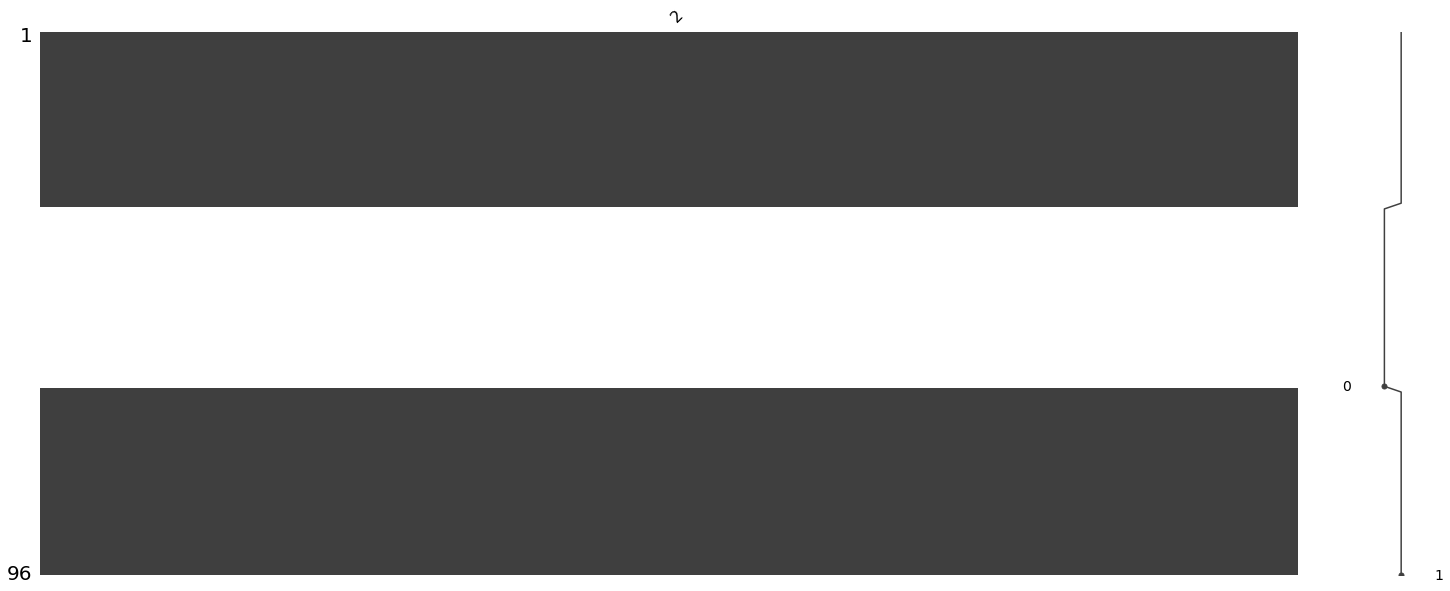

In [238]:
import matplotlib
import missingno as msno
%matplotlib inline

missingdata_df = g1.columns[g1.isnull().any()].tolist()
msno.matrix(g1[missingdata_df])

### locally weighted regression

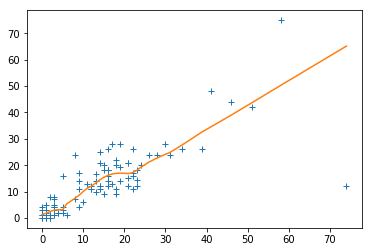

In [193]:
import numpy as np
import pylab as plt
import statsmodels.api as sm
s_df = g_combine3[g_combine3['2_x'].notnull()]
x = s_df['1_x']
y = s_df['2_x']
lowess = sm.nonparametric.lowess(y, x, frac=0.3)

plt.plot(x, y, '+')
plt.plot(lowess[:, 0], lowess[:, 1])
plt.show()

4hour

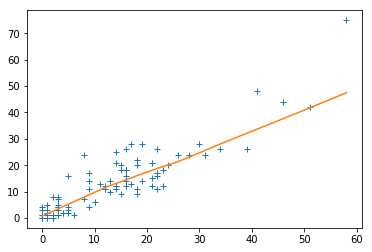

In [190]:
plt.plot(x, y, '+')
plt.plot(lowess[:, 0], lowess[:, 1])
plt.show()

8 hour

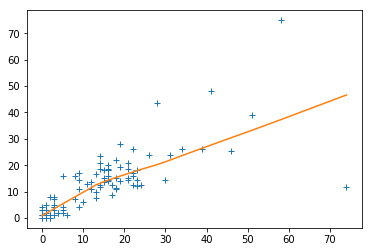

In [188]:
plt.plot(x, y, '+')
plt.plot(lowess[:, 0], lowess[:, 1])
plt.show()

### linear regression 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


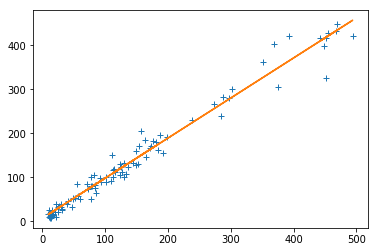

In [10]:
    g_combine2=g1.merge(g_o, left_index=True, right_index=True)
    f_df = g_combine2[g_combine2['2_x'].notnull()]    
    X_reg = f_df.loc[:, '1_x'].to_frame()
    Y_reg = f_df.loc[:, '2_x'].to_frame()
    regr = linear_model.LinearRegression()
    regr.fit(X_reg,Y_reg)
    #abs_residuals = np.absolute(Y_reg - regr.predict(X_reg))
    R2=regr.score(X_reg,Y_reg)
    #print(abs_residuals)
    pred= pd.DataFrame(regr.predict(g_combine2['1_x'].reshape(-1, 1)))
    g_combine2=g_combine2.merge(pred, left_index=True, right_index=True) 
 
    plt.plot(X_reg, Y_reg, '+')
    plt.plot(X_reg,pred)
    plt.show()

### Nearest Neighbors regression

In [290]:
# Generate sample data
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors

g_combine4=g1.merge(g_o, left_index=True, right_index=True)
k_df = g_combine4[g_combine4['2_x'].notnull()]    
X_reg = k_df.loc[:, '1_x'].to_frame()
Y_reg = k_df.loc[:, '2_x'].to_frame()
T=g_combine4['1_x'].reshape(-1, 1)

n_neighbors = 5
knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
y_ = knn.fit(X_reg, Y_reg).predict(T)


#n_neighbors = 5
#for i, weights in enumerate(['uniform', 'distance']):
#    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
#    y_ = knn.fit(X_reg, Y_reg).predict(T)
#    plt.figure(figsize=(30,10))
#    plt.subplot(2, 1, i + 1)
#    plt.scatter(X_reg, Y_reg, c='k', label='data')
#    plt.plot(T, y_, c='g', label='prediction')
#    plt.axis('tight')
#    plt.legend()
#    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,weights))
                                                                

#plt.show()
    
    
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


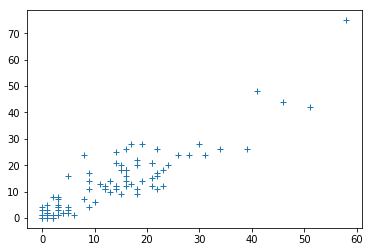

In [272]:
plt.plot(X_reg, Y_reg, '+')

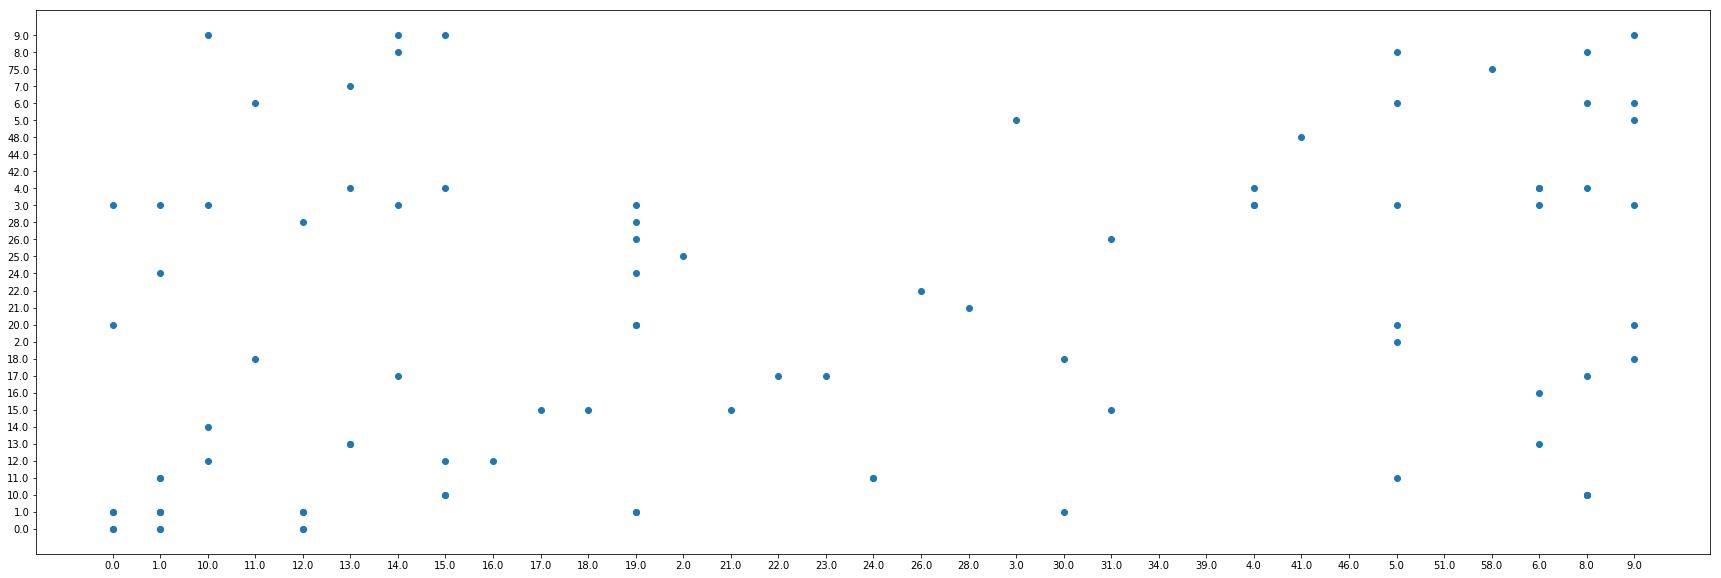

In [285]:
plt.figure(figsize=(30,10))
plt.scatter(X_reg, Y_reg)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


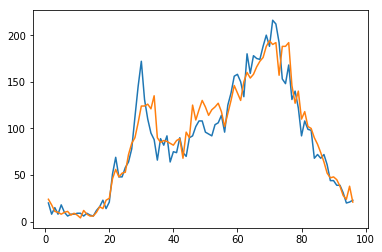

In [363]:
tt=df2.loc[df2['Loc_ID'] == 'U016SB']
tt.drop(tt.columns[[97]], axis=1, inplace=True)
tt=tt.set_index('Day').T
tt.index = tt.index.map(int)
plt.plot(tt)

In [458]:
r2=g_combine2_r[['2_y','2_x']].corr().loc['2_x', '2_y'] 

In [472]:
r2

0.8408163469577135

In [473]:
r1

0.8408163469577133